<a href="https://colab.research.google.com/github/MikJak75/Neutron_Reflect/blob/main/nr_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 125 (delta 4), reused 15 (delta 2), pack-reused 106
Receiving objects: 100% (125/125), 11.36 MiB | 25.01 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [64]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [65]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 96
#Number of epochs
num_epochs = 120
#Number of layers
num_layers = 1
#Number of neurons
num_neur=150 


In [66]:
cd Neutron_Reflect/

/content/Neutron_Reflect/Neutron_Reflect


In [67]:
#Stored those numpy arrays
data_path = './data/'
sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

In [68]:
sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype

((5942, 2, 96), (5942, 3), dtype('float64'), dtype('float64'))

In [69]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [70]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 96) (4753, 3) (594, 2, 96) (594, 3) (595, 2, 96) (595, 3)


In [71]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [72]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [73]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [74]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/120 	 train loss 0.07632322609424591 	 val loss 0.031659871339797974
EPOCH 2/120 	 train loss 0.004931556526571512 	 val loss 0.00020087826123926789
EPOCH 3/120 	 train loss 0.0001788680674508214 	 val loss 0.00018701786757446826
EPOCH 4/120 	 train loss 0.000166766214533709 	 val loss 0.00016475492157042027
EPOCH 5/120 	 train loss 0.000157876405864954 	 val loss 0.0001604605495231226
EPOCH 6/120 	 train loss 0.00014662118337582797 	 val loss 0.0001650206104386598
EPOCH 7/120 	 train loss 0.0001380218891426921 	 val loss 0.0001362703915219754
EPOCH 8/120 	 train loss 0.0001257809781236574 	 val loss 0.00014128501061350107
EPOCH 9/120 	 train loss 0.00011500564869493246 	 val loss 0.00012989462993573397
EPOCH 10/120 	 train loss 0.00010815940913744271 	 val loss 0.00011890604218933731
EPOCH 11/120 	 train loss 0.00010200389806414023 	 val loss 0.00011764339433284476
EPOCH 12/120 	 train loss 0.00010300063149770722 	 val loss 0.0001250943314516917
EPOCH 13/120 	 train loss 9.410

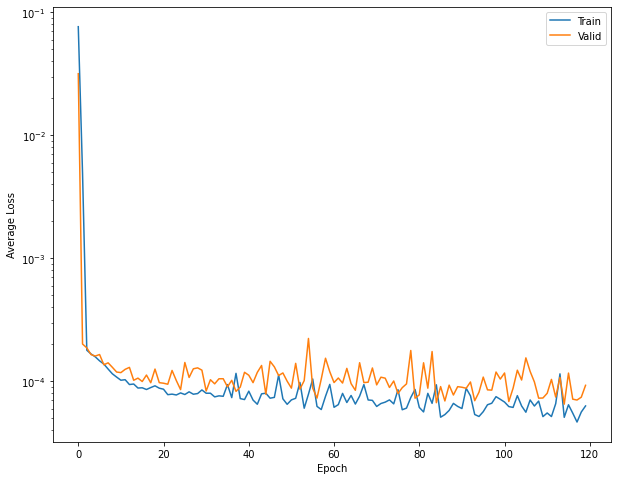

In [75]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 7.791237294441089e-05
For image 1, the loss = 0.00013285924796946347
For image 2, the loss = 8.438702207058668e-05
For image 3, the loss = 5.100845010019839e-05
For image 4, the loss = 0.00030451943166553974
For image 5, the loss = 4.9095964641310275e-05
For image 6, the loss = 0.00013051001587882638
For image 7, the loss = 0.00014065002324059606
For image 8, the loss = 0.00011298763274680823
For image 9, the loss = 2.3813157895347103e-05


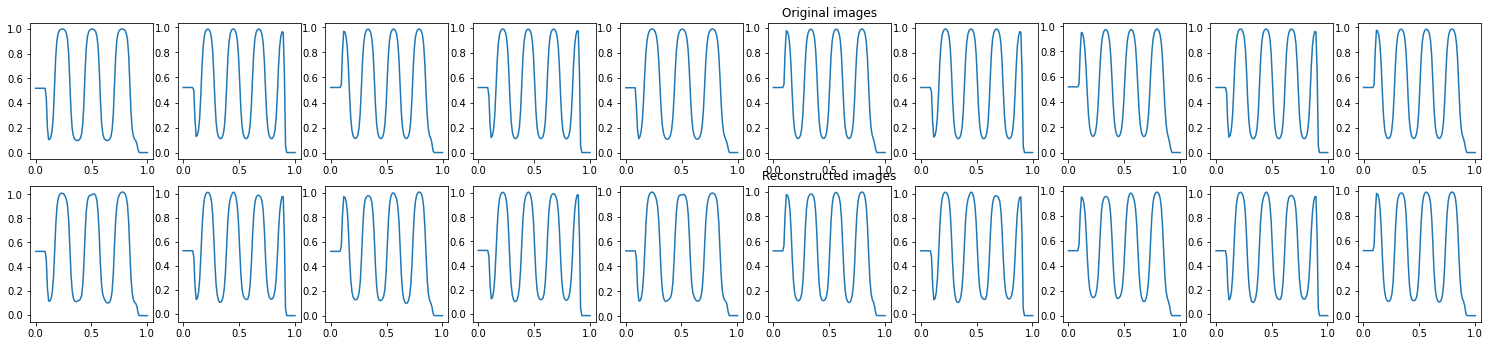

In [76]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([0.8535, 3.2010, 1.9924])
tensor([2.0861, 0.7476, 2.8647])


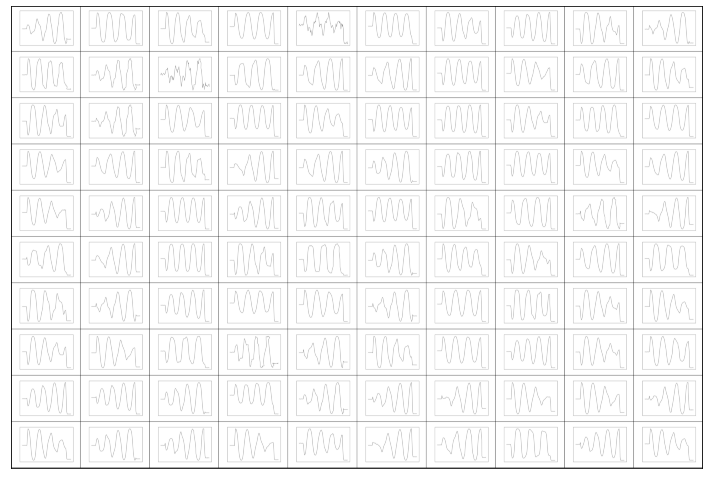

In [77]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [78]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [79]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-0.755352,4.242074,-1.652711,0.093,-0.0154,-0.53929
1,1.881620,2.432146,4.898135,0.199,-0.201,0.30314
2,-2.985087,3.757954,3.428346,0.194,-0.546,-0.51973
3,-2.993622,3.746527,3.435623,0.184,-0.308,-0.22831
4,3.752072,3.002130,-0.267519,0.194,0.321,0.53553
...,...,...,...,...,...,...
4748,3.210755,3.046394,0.080037,0.0645,0.527,0.1107
4749,1.720771,2.550559,4.511723,0.0824,-0.587,0.44883
4750,1.868865,2.435776,4.919549,0.165,-0.566,0.14929
4751,3.188289,3.060233,0.037609,0.0598,0.0177,0.26886


In [80]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 192]) torch.Size([4753, 192]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 192]) torch.Size([594, 192]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 192]) torch.Size([595, 192]) torch.Size([595, 3]) torch.Size([595, 3])


In [81]:
# #Saving encoder and decoder 
# torch.save(encoder.state_dict(),"./encoder.pt")
# torch.save(decoder.state_dict(),"./decoder.pt")

In [82]:
# #Reloading the encoder and decoderen
# encoder.load_state_dict(torch.load("./encoder.pt"))
# decoder.load_state_dict(torch.load("./decoder.pt"))

In [83]:
num_epochs = 600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [84]:
# #Running the MLP
# ### Define the loss function 
# loss_fn = torch.nn.MSELoss()

# ### Define the learning rate
# lr= 0.001

# ### Set the random seed for reproducible results
# torch.manual_seed(0)

# #model 
# model = mlp.MLP(dim=d,nlabel=nlabel)
# params_to_optimize = [
#     {'params': model.parameters()}
# ]

# #Define the optimizer
# optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# #Checking the device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

In [85]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [86]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/600 	 train loss 0.04694068431854248 	 val loss 0.028978947550058365
EPOCH 2/600 	 train loss 0.02262328751385212 	 val loss 0.025517523288726807
EPOCH 3/600 	 train loss 0.021427184343338013 	 val loss 0.02171201817691326
EPOCH 4/600 	 train loss 0.020595809444785118 	 val loss 0.02179562672972679
EPOCH 5/600 	 train loss 0.019488243386149406 	 val loss 0.02464175783097744
EPOCH 6/600 	 train loss 0.01942409761250019 	 val loss 0.02110791951417923
EPOCH 7/600 	 train loss 0.018601562827825546 	 val loss 0.020800111815333366
EPOCH 8/600 	 train loss 0.017889484763145447 	 val loss 0.018097827211022377
EPOCH 9/600 	 train loss 0.017112290486693382 	 val loss 0.01890619285404682
EPOCH 10/600 	 train loss 0.016754530370235443 	 val loss 0.01803138107061386
EPOCH 11/600 	 train loss 0.017028769478201866 	 val loss 0.017372271046042442
EPOCH 12/600 	 train loss 0.016290264204144478 	 val loss 0.01777828298509121
EPOCH 13/600 	 train loss 0.016601204872131348 	 val loss 0.01772774010

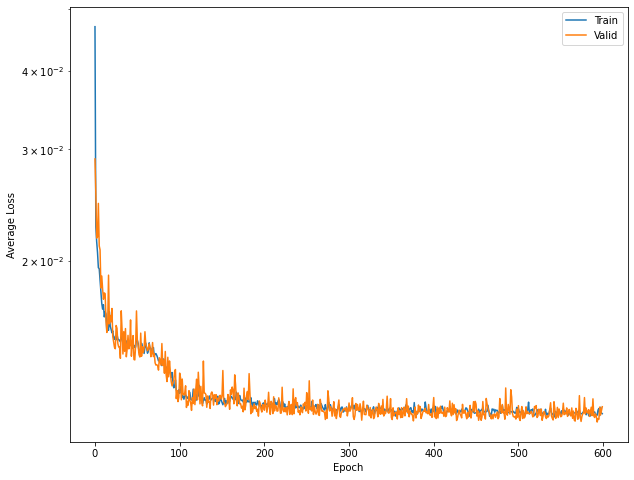

In [87]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [88]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.122471,-0.326880,-0.366385,0.103,-0.092,-0.19
1,0.152017,-0.334247,0.236758,0.117,-0.227,0.23043
2,0.164834,0.536404,-0.246886,0.173,0.391,-0.00732
3,0.150401,0.186712,0.440102,0.199,0.146,0.34164
4,0.151957,-0.315169,0.357126,0.137,-0.492,0.34414
...,...,...,...,...,...,...
590,0.151320,-0.283862,0.454585,0.117,-0.581,0.39373
591,0.162451,0.257853,-0.285645,0.168,0.299,-0.37307
592,0.129168,-0.267536,-0.421074,0.109,-0.469,-0.58795
593,0.068836,-0.436685,-0.000597,0.0759,-0.518,-0.02297


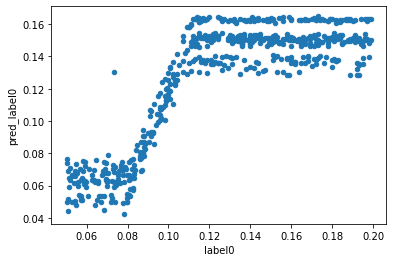

In [89]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

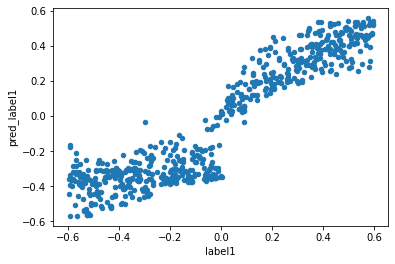

In [90]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

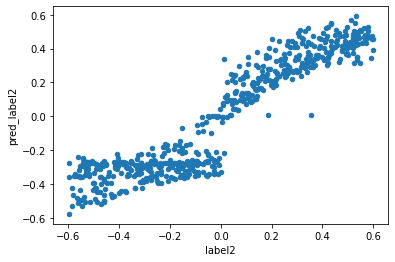

In [91]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [92]:
#Saving data into GitHub

# torch.save(train_latent_var,os.path.join(data_path,'train_latent_var.pt'))
# torch.save(train_latent_var,'train_labels_var.pt')

# torch.save(valid_latent_var,'valid_latent_var.pt')
# torch.save(valid_latent_var,'valid_labels_var.pt')

# torch.save(test_latent_var,'test_latent_var.pt')
# torch.save(test_latent_var,'test_labels_var.pt')


# torch.save(mlp_train_loader,'mlp_train_loader.pth')
# torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
# torch.save(mlp_test_loader,'mlp_test_loader.pth')

# !mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/

# torch.save(mlp_test_dataset,'mlp_test_dataset.pth')
# !mv mlp_test_dataset.pth /content/drive/MyDrive/neutron_reflectivity/

# #Saving also the pandas dataframe for the encoded sample

# #Having issues with the way a saved .csv and loaded one look like. 
# # df_encoded_samples.to_csv('encoded.csv', sep ='\t')
# # !mv encoded.csv /content/drive/MyDrive/neutron_reflectivity/

# #Using pickle instead.
# df_encoded_samples.to_pickle('df_encoded_samples.pkl')
# !mv df_encoded_samples.pkl /content/drive/MyDrive/neutron_reflectivity/

In [93]:
#Testing the model in experimental data
#Stored those numpy arrays
data_path = './exptdata/'

#Functions to read the sld and the param files
def read_sld_files(file_name):
    print(file_name)
    with open(file_name, 'r') as data:
        x = []
        y = []
        xy = [x,y]
        for line in data:
            p = line.split()
            # print(p)
            x.append(float(p[0]))
            y.append(float(p[1]))
            xy = x,y
            # array_xy = np.asarray(xy)

    return np.asarray(x),np.asarray(y)


folder = data_path


datafiles = [os.path.join(root, filename)
          for root, dirs, files in os.walk(folder)
          for filename in files
          if filename.lower().startswith('sld')]

for file in datafiles:
  dataindiv = read_sld_files(file)

dataindiv
# sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
# params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

./exptdata/sld_data.txt


(array([   0.    ,   19.7887,   39.5773,   59.366 ,   79.1546,   98.9433,
         118.732 ,  138.521 ,  158.309 ,  178.098 ,  197.887 ,  217.675 ,
         237.464 ,  257.253 ,  277.041 ,  296.83  ,  316.619 ,  336.407 ,
         356.196 ,  375.984 ,  395.773 ,  415.562 ,  435.35  ,  455.139 ,
         474.928 ,  494.716 ,  514.505 ,  534.294 ,  554.082 ,  573.871 ,
         593.66  ,  613.448 ,  633.237 ,  653.026 ,  672.814 ,  692.603 ,
         712.392 ,  732.18  ,  751.969 ,  771.758 ,  791.546 ,  811.335 ,
         831.124 ,  850.912 ,  870.701 ,  890.49  ,  910.278 ,  930.067 ,
         949.856 ,  969.644 ,  989.433 , 1009.22  , 1029.01  , 1048.8   ,
        1068.59  , 1088.38  , 1108.16  , 1127.95  , 1147.74  , 1167.53  ,
        1187.32  , 1207.11  , 1226.9   , 1246.69  , 1266.47  , 1286.26  ,
        1306.05  , 1325.84  , 1345.63  , 1365.42  , 1385.21  , 1404.99  ,
        1424.78  , 1444.57  , 1464.36  , 1484.15  , 1503.94  , 1523.73  ,
        1543.52  , 1563.3   , 1583.09 

In [94]:
print(len(datafiles))
print(type(dataindiv[0]))
dataindiv[1].shape


1
<class 'numpy.ndarray'>


(96,)

In [95]:
dataindv_arr = np.asarray(dataindiv)
# dataindv_arr.shape

exp_sld = []
exp_sld.append(dataindv_arr)
#dataindv_arr[0] = dataindv_arr[0] + 250
exp_sld_arr = np.asarray(exp_sld)
exp_sld_arr.shape

print(dataindv_arr.shape)
#dataindv_arr[0] = dataindv_arr[0] + 250
dataindv_arr[0]

exp_sld_trans = []
dataindv_arr_trans = dataindv_arr
dataindv_arr_trans[0] = dataindv_arr_trans[0] + 250
exp_sld_trans.append(dataindv_arr_trans)
exp_sld_trans_arr = np.asarray(exp_sld_trans)



print(exp_sld_trans_arr.shape)
#e

(2, 96)
(1, 2, 96)


[0.         0.01052635 0.02105265 0.031579   0.0421053  0.05263165
 0.06315801 0.07368452 0.0842105  0.09473701 0.10526352 0.1157895
 0.12631601 0.13684253 0.14736851 0.15789502 0.16842153 0.17894751
 0.18947402 0.2        0.21052651 0.22105302 0.231579   0.24210552
 0.25263203 0.26315801 0.27368452 0.28421103 0.29473701 0.30526352
 0.31579003 0.32631601 0.33684253 0.34736904 0.35789502 0.36842153
 0.37894804 0.38947402 0.40000053 0.41052704 0.42105302 0.43157954
 0.44210605 0.45263203 0.46315854 0.47368505 0.48421103 0.49473754
 0.50526405 0.51579003 0.52631655 0.53684199 0.54736904 0.55789608
 0.56842312 0.57895017 0.58947189 0.59999894 0.61052598 0.62105302
 0.63158007 0.64210711 0.65263415 0.6631612  0.67368292 0.68420997
 0.69473701 0.70526405 0.7157911  0.72631814 0.73684518 0.74736691
 0.75789395 0.768421   0.77894804 0.78947508 0.80000213 0.81052917
 0.82105622 0.83157794 0.84210498 0.85263203 0.86315907 0.87368611
 0.88421316 0.8947402  0.90526193 0.91578897 0.92631601 0.93684

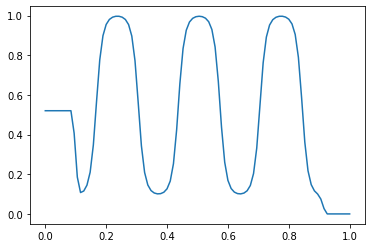

In [96]:
plt.plot(sld_arr[0][0],sld_arr[0][1])
print(sld_arr[0][0])

#transfrom at 0.085

In [97]:
#Normalizing the sld curves by min/max

#First finding the min/max
x_val=sld_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=sld_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

x-range =  0.0  to  1.0
y-range =  0.0  to  1.0


In [98]:
#Normalize
sld_arr[:,0,:] = (sld_arr[:,0,:] - x_min)/(x_max - x_min)
sld_arr[:,1,:] = (sld_arr[:,1,:] - y_min)/(y_max - y_min)

In [99]:
sld_arr.min(), sld_arr.max()

(0.0, 1.0)

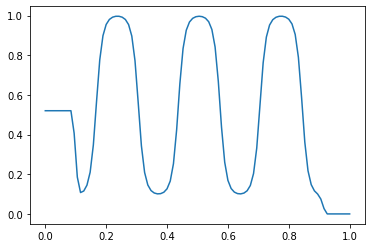

In [100]:
plt.plot(sld_arr[0][0],sld_arr[0][1])

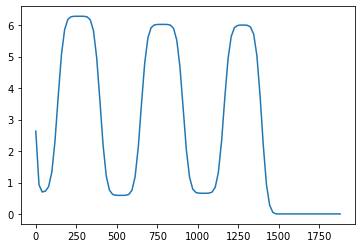

In [101]:
plt.plot(exp_sld_arr[0][0],exp_sld_arr[0][1])

In [102]:
x_val=exp_sld_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=exp_sld_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

exp_sld_arr[:,0,:] = (exp_sld_arr[:,0,:] - x_min)/(x_max - x_min)
exp_sld_arr[:,1,:] = (exp_sld_arr[:,1,:] - y_min)/(y_max - y_min)

type(exp_sld_arr)

x-range =  0.0  to  1879.92
y-range =  0.00808414  to  6.2808628569


numpy.ndarray

In [103]:
x_val=exp_sld_trans_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=exp_sld_trans_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

exp_sld_trans_arr[:,0,:] = (exp_sld_trans_arr[:,0,:] - x_min)/(x_max - x_min)
exp_sld_trans_arr[:,1,:] = (exp_sld_trans_arr[:,1,:] - y_min)/(y_max - y_min)

type(exp_sld_arr)

x-range =  250.0  to  2129.92
y-range =  0.00808414  to  6.2808628569


numpy.ndarray

In [104]:
encoder.eval().to(device)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=192, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=3, bias=True)
  )
)

In [105]:
decoder.eval().to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=192, bias=True)
  )
)

In [106]:
img = torch.from_numpy(exp_sld_arr).float()
img = img.view(img.size(0), -1).to(device)

In [107]:
encoder.eval()
decoder.eval()
with torch.no_grad(): 
  latent = encoder(img)
  decoded_img = decoder(latent)


[array([0.085     , 0.09552635, 0.10605265, 0.116579  , 0.1271053 ,
       0.13763165, 0.14815801, 0.15868452, 0.1692105 , 0.179737  ,
       0.19026352, 0.20078951, 0.21131602, 0.22184253, 0.2323685 ,
       0.242895  , 0.25342152, 0.26394752, 0.27447402, 0.285     ,
       0.2955265 , 0.306053  , 0.316579  , 0.32710552, 0.33763203,
       0.348158  , 0.35868454, 0.36921105, 0.37973702, 0.39026353,
       0.40079004, 0.411316  , 0.42184255, 0.43236905, 0.44289503,
       0.45342153, 0.46394804, 0.47447404, 0.48500055, 0.49552706,
       0.50605303, 0.5165795 , 0.52710605, 0.53763205, 0.5481585 ,
       0.55868506, 0.569211  , 0.57973754, 0.590264  , 0.60079   ,
       0.6113165 , 0.62184197, 0.63236904, 0.64289606, 0.65342313,
       0.66395015, 0.67447186, 0.6849989 , 0.69552594, 0.706053  ,
       0.71658003, 0.7271071 , 0.7376341 , 0.7481612 , 0.7586829 ,
       0.7692099 , 0.779737  , 0.790264  , 0.8007911 , 0.8113181 ,
       0.8218452 , 0.8323669 , 0.84289396, 0.853421  , 0.8639

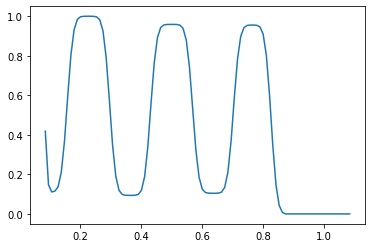

In [108]:
img_arr = img.cpu().reshape(in_d1,in_d2).numpy()
img_arr_trans = list(img_arr)
img_arr_trans[0] = img_arr_trans[0] + 0.085

plt.plot(img_arr_trans[0],img_arr_trans[1]) 
print(img_arr_trans)

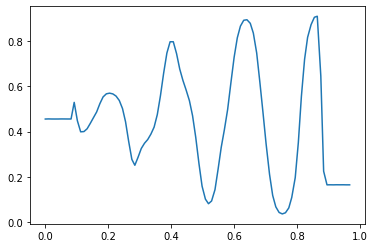

In [109]:
img_trans = torch.from_numpy(exp_sld_trans_arr).float()
img_trans = img.view(img.size(0), -1).to(device) 

encoder.eval()
decoder.eval()
with torch.no_grad(): 
  latent = encoder(img_trans)
  decoded_img_trans = decoder(latent)

plt.plot(decoded_img_trans.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_trans.cpu().reshape(in_d1,in_d2).numpy()[1]) 


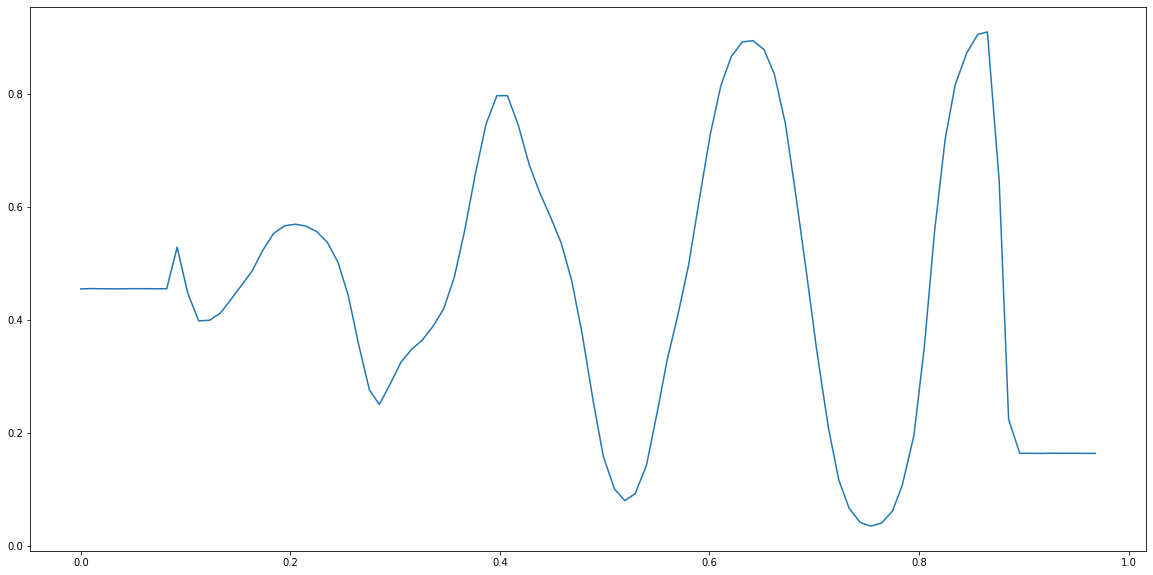

In [114]:
plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 


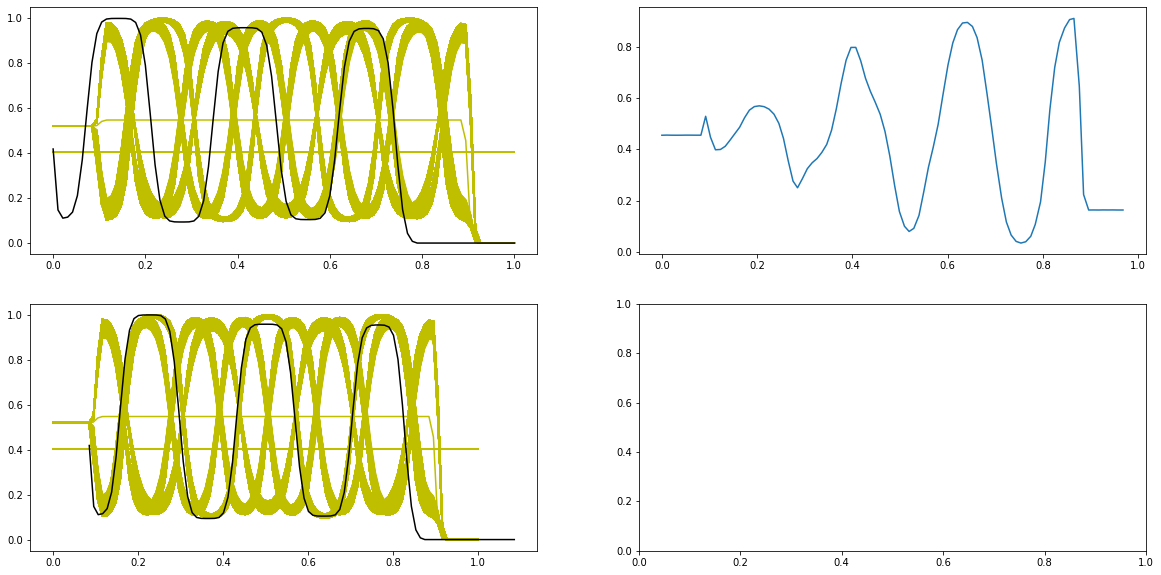

In [111]:
plt.rcParams['figure.figsize'] = [20, 10]

figure, axis = plt.subplots(2,2)

#f1 = plt.figure(1)
for x in range(sld_arr.shape[0]):
  axis[0][0].plot(sld_arr[x][0], sld_arr[x][1], 'y')
axis[0][0].plot(img_arr[0], img_arr[1], 'k')

#f2 = plt.figure(2)
axis[0][1].plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 

for x in range(sld_arr.shape[0]):
  axis[1][0].plot(sld_arr[x][0], sld_arr[x][1], 'y')
axis[1][0].plot(img_arr_trans[0], img_arr_trans[1], 'k')

#figure, axis = plt.subplots(1, 2)
#axis[0].plot(f1)
#axis[1].plot(f2)

plt.show()

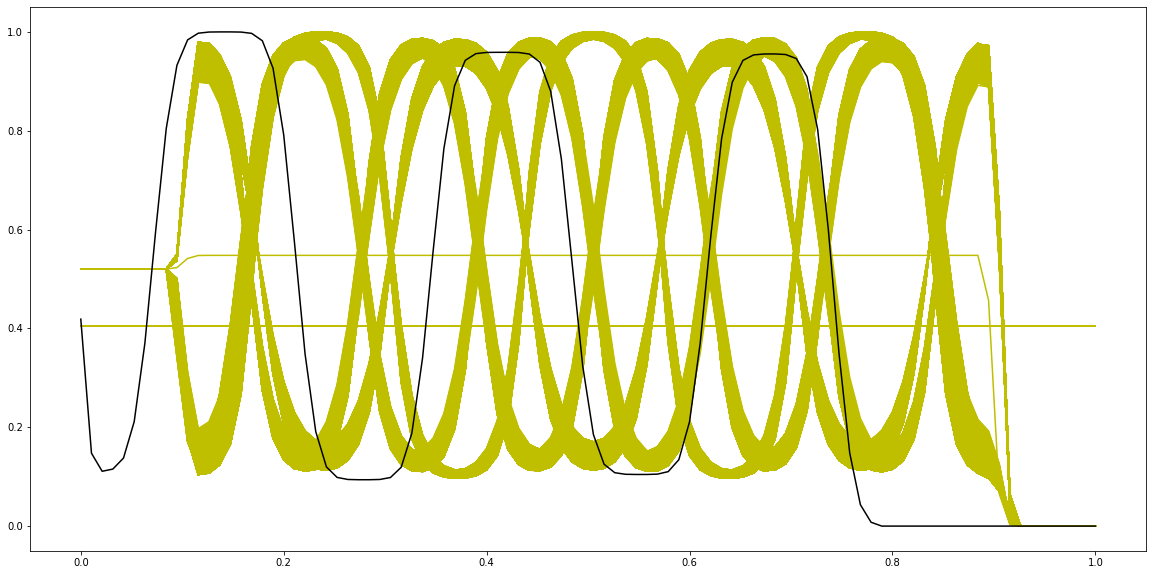

In [112]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0], sld_arr[x][1], 'y')
plt.plot(exp_sld_arr[0][0], exp_sld_arr[0][1], 'k')
#plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1], 'k') 
plt.show()

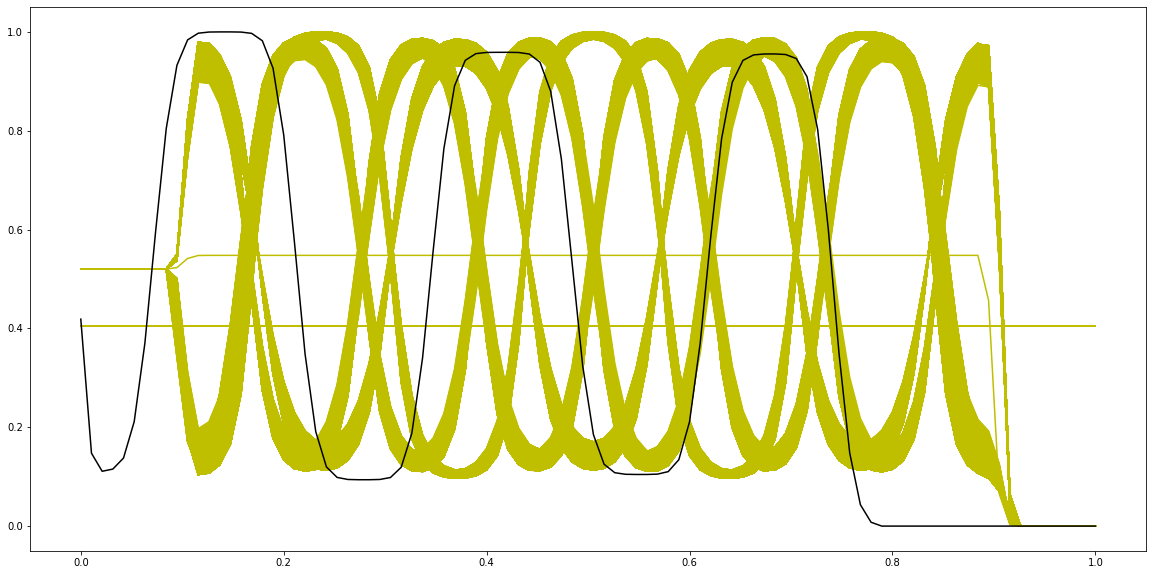

In [113]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0], sld_arr[x][1], 'y')
plt.plot(exp_sld_arr[0][0], exp_sld_arr[0][1], 'k')
#plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1], 'k') 
plt.show()